# Streaming

## Using LangGraph API

Tell about server part of LangGraph Studio and prefered approach to build graphs

In [9]:
from langgraph_sdk import get_client

# URL = "http://localhost:61693"
URL = "http://127.0.0.1:2024"  # This is the server address
client = get_client(url=URL)

# Search all hosted graphs
assistants = await client.assistants.search()
assistants

[{'assistant_id': '45d7f46b-abb2-5734-9fb9-b1edc76c6546',
  'graph_id': 'dev_mentor',
  'config': {},
  'context': {},
  'metadata': {'created_by': 'system'},
  'name': 'dev_mentor',
  'created_at': '2025-08-15T17:20:59.259433+00:00',
  'updated_at': '2025-08-15T17:20:59.259433+00:00',
  'version': 1,
  'description': None},
 {'assistant_id': 'ae2c32e4-0e45-57db-b449-103064dcb967',
  'graph_id': 'directive_memory_bot',
  'config': {},
  'context': {},
  'metadata': {'created_by': 'system'},
  'name': 'directive_memory_bot',
  'created_at': '2025-08-15T17:20:59.156435+00:00',
  'updated_at': '2025-08-15T17:20:59.156435+00:00',
  'version': 1,
  'description': None},
 {'assistant_id': '89e77aa6-c452-5416-bd83-721b80077ae5',
  'graph_id': 'chatbot_long_term_memory',
  'config': {},
  'context': {},
  'metadata': {'created_by': 'system'},
  'name': 'chatbot_long_term_memory',
  'created_at': '2025-08-15T17:20:59.046553+00:00',
  'updated_at': '2025-08-15T17:20:59.046553+00:00',
  'version'

In [10]:
assistants[0]["assistant_id"]

'45d7f46b-abb2-5734-9fb9-b1edc76c6546'

In [11]:
from langchain_core.messages import HumanMessage

# Create a new thread
thread = await client.threads.create()

final_state = await client.runs.wait(
    thread_id=thread["thread_id"],
    assistant_id="8a4ac7a4-50eb-5206-98cc-4a72345cb1f7",
    input={"question": "Hi, I’m working on a Python project, and I’m stuck with handling API responses."}
)

final_state

{'messages': [{'content': 'Hi, I’m working on a Python project, and I’m stuck with handling API responses.',
   'additional_kwargs': {},
   'response_metadata': {},
   'type': 'human',
   'name': None,
   'id': '202bdeb0-5874-4a94-83a9-59ff924b0d72',
   'example': False},
  {'content': "I'd be happy to help! Could you provide more details about the API you are working with and what specific issues or questions you have regarding handling the responses?",
   'additional_kwargs': {'refusal': None},
   'response_metadata': {'token_usage': {'completion_tokens': 31,
     'prompt_tokens': 92,
     'total_tokens': 123,
     'completion_tokens_details': {'accepted_prediction_tokens': 0,
      'audio_tokens': 0,
      'reasoning_tokens': 0,
      'rejected_prediction_tokens': 0},
     'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
    'model_name': 'gpt-4o-mini-2024-07-18',
    'system_fingerprint': 'fp_1542007cca',
    'id': 'chatcmpl-C4spusGVUGCQFTPU6ENdX83gEHwP6',
    'se

In [12]:
final_state = await client.runs.wait(
    thread_id=thread["thread_id"],
    assistant_id="8a4ac7a4-50eb-5206-98cc-4a72345cb1f7",
    input={"question": "Sorry what was my previous question?"}
)

final_state["answer"]

"You mentioned that you are working on a Python project and are having trouble handling API responses. If you could provide more details about the specific issues you're encountering, I can assist you better!"

In [13]:
final_state = await client.runs.wait(
    thread_id=thread["thread_id"],
    assistant_id="8a4ac7a4-50eb-5206-98cc-4a72345cb1f7",
    input={"question": "Ahh, yeah right! So I’m mostly struggling with parsing JSON responses. Sometimes the structure isn’t what I expect, and it breaks my code."}
)

final_state

{'messages': [{'content': 'Ahh, yeah right! So I’m mostly struggling with parsing JSON responses. Sometimes the structure isn’t what I expect, and it breaks my code.',
   'additional_kwargs': {},
   'response_metadata': {},
   'type': 'human',
   'name': None,
   'id': 'c7590e25-f838-4293-acb4-3acc1b724174',
   'example': False},
  {'content': 'I understand! When dealing with JSON responses, unexpected structures can definitely be a challenge. Here are some tips to help you handle them more effectively:\n\n1. **Check the Structure**: Always print or log the entire JSON response first to understand its structure. You can use `print(response.json())` after parsing it with `response.json()`.\n\n2. **Use `try-except` Blocks**: To handle potential parsing errors, wrap your JSON parsing logic in a `try-except` block. This will allow you to catch and manage exceptions gracefully.\n\n   ```python\n   import requests\n\n   response = requests.get(\'your_api_endpoint\')\n   try:\n       data = r

## Streaming

Observe the difference between constructing graph manually & using LangGraph Studio

### Define chatbot graph

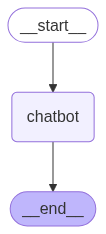

In [14]:
from langchain_openai import ChatOpenAI
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_core.messages import HumanMessage, SystemMessage, RemoveMessage


# OPENAI_API_KEY environment variable must be set
llm = ChatOpenAI(model="gpt-4o-mini")

# System message
chatbot_system_message = SystemMessage(content=("""
You are a helpful and knowledgeable chatbot assistant. 
Your goal is to provide clear and accurate answers to user questions based on the information they provide. 
Stay focused, concise, and ensure your responses are relevant to the context of the conversation. 
If you don’t have enough information, ask for clarification.”
"""))


# Nodes
def chatbot(state: MessagesState) -> MessagesState:
    response = llm.invoke([chatbot_system_message] + state["messages"]);
    return MessagesState(messages = [response])


# Graph
workflow = StateGraph(MessagesState)
workflow.add_node(chatbot)

workflow.add_edge(START, "chatbot")
workflow.add_edge("chatbot", END)


memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

Streaming modes:

- updates (exposes only new data)
- values (always shows the whole state)
- messages
- debug
- custom

### Stream_mode=updates

In [16]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

user_input = HumanMessage(content="Hi, I’m working on a Python project, and I’m stuck with handling API responses.")
for event in graph.stream({"messages": [user_input]}, config, stream_mode="updates"):
    print(event)

{'chatbot': {'messages': [AIMessage(content='Sure! To help you effectively, could you provide more details about the following?\n\n1. Which API are you working with?\n2. What kind of data are you expecting in the response?\n3. What specific issues are you facing (e.g., parsing JSON, error handling, etc.)? \n\nThis information will help me assist you better!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 69, 'prompt_tokens': 147, 'total_tokens': 216, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-C4tB23e0kufqJcsTz433ZIbNlWnJV', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--663620e2-afcd-4049-a04a-5c572c6dfdf4-0', usage_metadata={'input_tokens': 147, 'output

In [17]:
user_input = HumanMessage(content="Sorry what was my previous question?")
for event in graph.stream({"messages": [user_input]}, config, stream_mode="updates"):
    for m in event['chatbot']['messages']:
        m.pretty_print()

================================== Ai Message ==================================

Your previous message mentioned that you are working on a Python project and are stuck with handling API responses. If you have any specific questions or issues regarding this, feel free to share!


### Stream_mode=values

In [18]:
config = {"configurable": {"thread_id": "2"}}

user_input = HumanMessage(content="Hi, I’m working on a Python project, and I’m stuck with handling API responses.")
for event in graph.stream({"messages": [user_input]}, config, stream_mode="values"):
    print(event)

{'messages': [HumanMessage(content='Hi, I’m working on a Python project, and I’m stuck with handling API responses.', additional_kwargs={}, response_metadata={}, id='69d8c0a4-f168-4529-90cf-c560da6e5c6a')]}
{'messages': [HumanMessage(content='Hi, I’m working on a Python project, and I’m stuck with handling API responses.', additional_kwargs={}, response_metadata={}, id='69d8c0a4-f168-4529-90cf-c560da6e5c6a'), AIMessage(content="Sure! Could you provide more details about the specific issue you're facing with handling API responses in your Python project? For example, are you having trouble with parsing JSON data, handling errors, or anything else?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 41, 'prompt_tokens': 92, 'total_tokens': 133, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}

In [19]:
config = {"configurable": {"thread_id": "2"}}

user_input = HumanMessage(content="Hi, I’m working on a Python project, and I’m stuck with handling API responses.")
for event in graph.stream({"messages": [user_input]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
    print("\n")
    print("#"*100)
    print("\n")

================================ Human Message =================================

Hi, I’m working on a Python project, and I’m stuck with handling API responses.
================================== Ai Message ==================================

Sure! Could you provide more details about the specific issue you're facing with handling API responses in your Python project? For example, are you having trouble with parsing JSON data, handling errors, or anything else?
================================ Human Message =================================

Hi, I’m working on a Python project, and I’m stuck with handling API responses.


####################################################################################################


================================ Human Message =================================

Hi, I’m working on a Python project, and I’m stuck with handling API responses.
================================== Ai Message ==================================

Sure! Could you provid

### Streaming deeper (updates inside Node) - a.k.a. "streaming LLM tokens from a specific node"

In [20]:
config = {"configurable": {"thread_id": "4"}}

user_input = HumanMessage(content="Hi, I’m working on a Python project, and I’m stuck with handling API responses.")
for event in graph.stream({"messages": [user_input]}, config, stream_mode="messages"):
    print(event)

# so we have a message with content and metadata

(AIMessageChunk(content='', additional_kwargs={}, response_metadata={}, id='run--bc2c83b5-994a-40b2-928f-49999aa04e18'), {'thread_id': '4', 'langgraph_step': 1, 'langgraph_node': 'chatbot', 'langgraph_triggers': ('branch:to:chatbot',), 'langgraph_path': ('__pregel_pull', 'chatbot'), 'langgraph_checkpoint_ns': 'chatbot:9b6b63c0-aade-1c97-15ce-136b53f69ebe', 'checkpoint_ns': 'chatbot:9b6b63c0-aade-1c97-15ce-136b53f69ebe', 'ls_provider': 'openai', 'ls_model_name': 'gpt-4o-mini', 'ls_model_type': 'chat', 'ls_temperature': None})
(AIMessageChunk(content='I', additional_kwargs={}, response_metadata={}, id='run--bc2c83b5-994a-40b2-928f-49999aa04e18'), {'thread_id': '4', 'langgraph_step': 1, 'langgraph_node': 'chatbot', 'langgraph_triggers': ('branch:to:chatbot',), 'langgraph_path': ('__pregel_pull', 'chatbot'), 'langgraph_checkpoint_ns': 'chatbot:9b6b63c0-aade-1c97-15ce-136b53f69ebe', 'checkpoint_ns': 'chatbot:9b6b63c0-aade-1c97-15ce-136b53f69ebe', 'ls_provider': 'openai', 'ls_model_name': 'g

In [21]:
config = {"configurable": {"thread_id": "4"}}

user_input = HumanMessage(content="Ahh, yeah right! So I’m mostly struggling with parsing JSON responses. Sometimes the structure isn’t what I expect, and it breaks my code.")
for msg, metadata in graph.stream({"messages": [user_input]}, config, stream_mode="messages"):
    if (metadata['langgraph_node'] == 'chatbot'):
        print(msg.content, end="")

# same style of outputing data as in chat app (a token by token)

Parsing JSON responses can sometimes be tricky due to variable structures. Here are a few tips to handle potential issues:

1. **Use `try-except` Blocks**: Wrap your parsing code in try-except blocks to handle potential errors gracefully.

   ```python
   import json

   try:
       response_data = json.loads(api_response)  # Replace api_response with your API response
   except json.JSONDecodeError:
       print("Failed to decode JSON")
   ```

2. **Check the Response Structure**: Before accessing certain keys, ensure they exist to avoid `KeyError`.

   ```python
   if 'key' in response_data:
       value = response_data['key']
   else:
       print("Key not found in response")
   ```

3. **Use `get()` Method**: The `get()` method returns `None` if a key doesn't exist, preventing errors.

   ```python
   value = response_data.get('key', default_value)  # Use a default if the key is missing
   ```

4. **Print the Response**: When debugging, print the entire JSON response to understand 

## Streaming with LangGraph API

In [23]:
from langgraph_sdk import get_client

#URL = "http://localhost:61693"
URL = "http://127.0.0.1:2024"  # This is the server address
client = get_client(url=URL)

assistants = await client.assistants.search()
assistants

[{'assistant_id': '45d7f46b-abb2-5734-9fb9-b1edc76c6546',
  'graph_id': 'dev_mentor',
  'config': {},
  'context': {},
  'metadata': {'created_by': 'system'},
  'name': 'dev_mentor',
  'created_at': '2025-08-15T17:20:59.259433+00:00',
  'updated_at': '2025-08-15T17:20:59.259433+00:00',
  'version': 1,
  'description': None},
 {'assistant_id': 'ae2c32e4-0e45-57db-b449-103064dcb967',
  'graph_id': 'directive_memory_bot',
  'config': {},
  'context': {},
  'metadata': {'created_by': 'system'},
  'name': 'directive_memory_bot',
  'created_at': '2025-08-15T17:20:59.156435+00:00',
  'updated_at': '2025-08-15T17:20:59.156435+00:00',
  'version': 1,
  'description': None},
 {'assistant_id': '89e77aa6-c452-5416-bd83-721b80077ae5',
  'graph_id': 'chatbot_long_term_memory',
  'config': {},
  'context': {},
  'metadata': {'created_by': 'system'},
  'name': 'chatbot_long_term_memory',
  'created_at': '2025-08-15T17:20:59.046553+00:00',
  'updated_at': '2025-08-15T17:20:59.046553+00:00',
  'version'

In [24]:
thread = await client.threads.create()

input_message = HumanMessage(content="Hi, I’m working on a Python project, and I’m stuck with handling API responses.")

async for part in client.runs.stream(
        thread["thread_id"], 
        assistant_id="8a4ac7a4-50eb-5206-98cc-4a72345cb1f7", 
        input={"messages": [input_message]}, 
        stream_mode="messages"):
    print(part)

# check event types

StreamPart(event='metadata', data={'run_id': '1f07a043-e910-62ea-bdce-04e7b60e25c4', 'attempt': 1})
StreamPart(event='messages/metadata', data={'run--806e674a-a9d9-487b-8b95-447d0ce8eb02': {'metadata': {'created_by': 'system', 'graph_id': 'chatbot', 'assistant_id': '8a4ac7a4-50eb-5206-98cc-4a72345cb1f7', 'run_attempt': 1, 'langgraph_version': '0.6.4', 'langgraph_api_version': '0.2.128', 'langgraph_plan': 'developer', 'langgraph_host': 'self-hosted', 'langgraph_api_url': 'http://127.0.0.1:2024', 'host': '127.0.0.1:2024', 'accept-encoding': 'gzip, deflate, zstd', 'connection': 'keep-alive', 'user-agent': 'langgraph-sdk-py/0.2.0', 'x-api-key': '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', 'content-length': '350', 'content-type': 'application/json', 'accept': 'text/event-stream', 'cache-control': 'no-store', 'x-request-id': 'b5ac56b6-b8e2-4cb7-a1df-96ba3bc952a7', 'langgraph_auth_user_id': '', 'langgraph_request_id': 'b5ac56b6-b8e2-4cb7-a1df-96ba3bc952a7', 'run_id': '1f07a043-e910-

In [31]:
from langchain_core.messages import convert_to_messages

thread = await client.threads.create()
input_message = HumanMessage(content="Should I invest in Tesla stocks?")

async for event in client.runs.stream(
            thread["thread_id"], 
            assistant_id="b7480eb0-6390-53a5-9bc4-29bf27cbd1c4", 
            input={"messages": [input_message]}, 
            stream_mode="values"):
    messages = event.data.get('messages',None)
    if messages:
        print(convert_to_messages(messages)[-1])

# display content only with convert_to_messages util

content='Should I invest in Tesla stocks?' additional_kwargs={} response_metadata={} id='c4651ac5-cbbe-4ae7-882c-e5a3d1b4d486'
content='' additional_kwargs={'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 392, 'output_tokens': 17, 'total_tokens': 409, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}, 'tool_calls': [{'id': 'call_tKMcPnaUu9CxyYNgie4GV2La', 'function': {'arguments': '{"__arg1":"Tesla"}', 'name': 'lookup_stock_symbol'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 392, 'total_tokens': 409, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-C4tQK0Ucw9vMlTDUqKeNPzpaHoX6G', 'service_tier': 

AttributeError: 'NoneType' object has no attribute 'get'